#### Template
*Machine Learning and Neural Networks on “Deep Learning of a public dataset”*

Type annotation for return types. def sample() -> int .

sample  function returns  an int

#### Motivation
Integrating artificial intelligence into medical research requires interdisciplinary collaborations, which imposes a barrier to early phase clinical studies or work by junior researcher. Two publications by Panch, T.(2019) and Rajkomar, A (2023) published in BMC Medicine, reiterated the difficulties in assembling clinical and machine learning experts for early phase project. Conducting robust efficacy and safety evaluation is more difficult with artificial intelligence [5,10].
##### Project Template
My chosen template is CM3050 Machine Learning and Neural Networks on “Deep Learning of a public dataset”.

Objectives:
- A simple jupyter notebook-based pipeline.
- Allow import of edf files. This allows import from EEG machine.
- Preprocessing includes segmenting time series, and value standardisation.
- Implementing two algorithms, a neural network and a non-neural network based algorithm.


[CHB-Mit Seizure Dataset.](https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset/data)

In [1]:
# Array and file access libraries
import numpy as np
import pandas as pd
import os
import importlib.util as util
from matplotlib import pyplot as plt

In [2]:
from scipy.signal import  welch, butter, filtfilt  # estimate signal power across all frequencies
import pywt # wavelet transformation algorithm. Python package to install is called PyWavelets

In [3]:
# Scikit-learn library for preprocessing and optimisation search algorithm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler


In [4]:
# machine learning tensorflow library
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, MaxPooling1D, Flatten, Input, Dense, Dropout
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint

#### Rapid prototyping
Uses CHM-MIT dataset, which has been preprocessed into Numpy arrays. Smaller size and has window segmentation of 1 second (Badea, 2021) [1].
This dataset provides
  - Non-balanced seizure and non-seizure classes in proportion of original raw data, as training and testing sample sets
  - For validation, an unbalanced and a balanced set are provided.
> Non-balanced dataset is used for this section (rapid prototyping)

In [12]:
# parse Badea's files and export to signals containing data and labels containing seizure or non seizure labels
# files in npz, numpy format

for root, dirs, files in os.walk('data'):
    for file in files:
        print(os.path.join(root, file))

# Data sampled at frequency 256 Hz from 23 channels , n samples.
# Each sample represents 1 second.
# Training, Testing , Validation data have shape (n,23,256).
# npz file may be saved with pickle if strings or complex objects are present

# load unbalanced training datasets
npz_train1 = np.load('data/eeg-seizure_train.npz', allow_pickle=True)
train_signals = npz_train1['train_signals']
train_labels = npz_train1['train_labels']
print(f"Training data (signals) have shape {train_signals.shape}")
print(f"Training labels have shape {train_labels.shape}")

# loads unbalanced validation datasets
npz_val1 = np.load('data/eeg-seizure_val.npz', allow_pickle=True)
val_signals = npz_val1['val_signals']
val_labels = npz_val1['val_labels']
print(f"Validation data (signals) have shape {val_signals.shape}")
print(f"Validation labels have shape {val_labels.shape}")

# loads unbalanced testing unbalanced datasets
npz_test1 = np.load('data/eeg-seizure_test.npz', allow_pickle=True)
test_signals = npz_test1['test_signals']
print(f"Test data (signals) have shape {test_signals.shape}")
# no test label file is available as this dataset if from a kaggle competition
print(npz_test1.keys())

# loads balanced validation datasets
npz_balanced1 = np.load('data/eeg-seizure_val_balanced.npz', allow_pickle=True)
npz_balanced1.keys()
val_balanced_signals = npz_balanced1['val_signals']
val_balanced_labels = npz_balanced1['val_labels']



data\eeg-predictive_train.npz
data\eeg-predictive_val.npz
data\eeg-predictive_val_balanced.npz
data\eeg-seizure_test.npz
data\eeg-seizure_train.npz
data\eeg-seizure_val.npz
data\eeg-seizure_val_balanced.npz
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\ANNOTATORS
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\RECORDS
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\RECORDS-WITH-SEIZURES
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\SHA256SUMS.txt
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\shoeb-icml-2010.pdf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\SUBJECT-INFO
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01-summary.txt
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_01.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_02.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf.seizures
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_04.edf
data\raw_dat

In [20]:
unique, count = np.unique(train_labels, return_counts=True)
print("unique",unique,"count",count)

unique [0 1] count [29592  8074]


In [6]:
train_signals.shape, train_labels.shape


((37666, 23, 256), (37666,))

#### Baseline models for comparison

##### Baseline common sense comparator

CHB-MIT is the chosen dataset, as it has been well studied, and contains the standard 23 channels recordings typical of clinical practice recording. Chollet (2018) advocated a step wise baseline-based approach in building neural network. He argued the black box nature of neural network models have to be anchored on objective evaluation before building increasingly complex models.
Precision - "Of all model results labelled as positive, how many were true positive?
Recall - "Of all true positive instances, how many were correctly identified by model?"

CHB-MIT dataset contains 198 identified seizures over 916 hours of recordings. An unbalanced dataset. Typical seizure recordings span seconds to minutes. Assuming an average seizure recording of 1 minute each, there will be 3-4 hours of seizure recordings. This comprises less than 1% of all recordings. An algorithm that returns no seizure for any input will achieve accuracy of over 99%. Clearly recall and precision will be zero.
Conversely, predicting all samples as having seizure result in low accuracy, recall and precision scores, less than 0.01.  This sets the threshold target bar too low. A better approach would be to rely on Wang’s (2020) survey of epileptologists. A surveyed consensus among seizure experts is to accept sensitivity of 80% in automated diagnosis [30].

##### Baseline densely connected model
Every neuron in each layer is connected to all neurons in preceding layer. Each neuron is also connected to all neurons in next layer.

In [24]:
class BaseDense:
    def __init__(self, train_data, train_labels, validation_data, validation_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        self.validation_data = validation_data
        self.validation_labels = validation_labels
        self.model = None
        self.recall = None

    def train(self):
        inputs = Input(shape=self.train_data.shape[1:])
        x = Flatten()(inputs)
        x = Dense(16, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)

        callbacks_ = [ModelCheckpoint("dense_baseline.keras",
                                     save_best_only = True)]
        model.compile(optimizer='adam',loss='binary_crossentropy', metrics =['mae', 'Recall'])
        history = model.fit(self.train_data, self.train_labels,
                            epochs=10,
                            validation_data=(self.validation_data, self.validation_labels),
                            callbacks=callbacks_,
                            verbose=0)

        print(f"Training loss , mae , recall : {model.evaluate(self.validation_data, self.validation_labels)}")
        self.model = model
        self.recall = history.history['val_recall']

    def evaluate(self):
        # Evaluate model
        history_loss, history_mae, history_recall = self.model.evaluate(self.validation_data, self.validation_labels)
        print(f" loss: {history_loss:.4f} , mae: {history_mae:.4f} , recall: {history_recall:.4f}")

        # returns array of probability (float) of binary outcome
        # convert to integer. Without astype(int) returns array of True, False
        y_pred = ( self.model.predict(self.validation_data) > 0.5 ).astype(int)
        y_true = self.validation_labels

        # print confusion matrix
        print("\n Confusion Matrix:")
        cm_labels = ['Non-seizure', 'Seizure']
        cm = confusion_matrix(y_true, y_pred)
        display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
        display_cm.plot(cmap=plt.cm.Blues)
        plt.show()

        #plot recall vs epochs
        epochs = np.arange(1, len(self.recall) + 1)
        plt.plot(epochs, self.recall,label='Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.show()

    def pre_process(self):
        scalar = StandardScaler()
        self.train_data = scalar.fit_transform(self.train_data)
        self.validation_data = scalar.transform(self.validation_data)




In [8]:
# Training on training data
base_nn = BaseDense(train_signals,train_labels,val_signals,val_labels)
base_nn.train()



Epoch 1/10
1178/1178 [==============================] - 16s 13ms/step - loss: 15.1971 - mae: 0.3468 - recall: 0.4771 - val_loss: 1.3338 - val_mae: 0.2920 - val_recall: 0.4202
Epoch 2/10
1178/1178 [==============================] - 12s 10ms/step - loss: 0.5142 - mae: 0.2819 - recall: 0.4166 - val_loss: 0.5567 - val_mae: 0.2872 - val_recall: 0.3751
Epoch 3/10
1178/1178 [==============================] - 13s 11ms/step - loss: 0.4376 - mae: 0.2504 - recall: 0.4345 - val_loss: 0.5027 - val_mae: 0.2815 - val_recall: 0.4484
Epoch 4/10
1178/1178 [==============================] - 17s 14ms/step - loss: 0.4110 - mae: 0.2314 - recall: 0.4542 - val_loss: 0.5357 - val_mae: 0.2836 - val_recall: 0.4975
Epoch 5/10
1178/1178 [==============================] - 16s 14ms/step - loss: 0.4128 - mae: 0.2262 - recall: 0.4585 - val_loss: 0.8089 - val_mae: 0.2314 - val_recall: 0.1156
Epoch 6/10
1178/1178 [==============================] - 14s 12ms/step - loss: 0.4322 - mae: 0.2236 - recall: 0.4579 - val_loss: 0

253/253 [==============================] - 2s 7ms/step - loss: 0.6745 - mae: 0.2790 - recall: 0.6058
 loss: 0.6745 , mae: 0.2790 , recall: 0.6058
253/253 [==============================] - 2s 7ms/step

 Confusion Matrix:


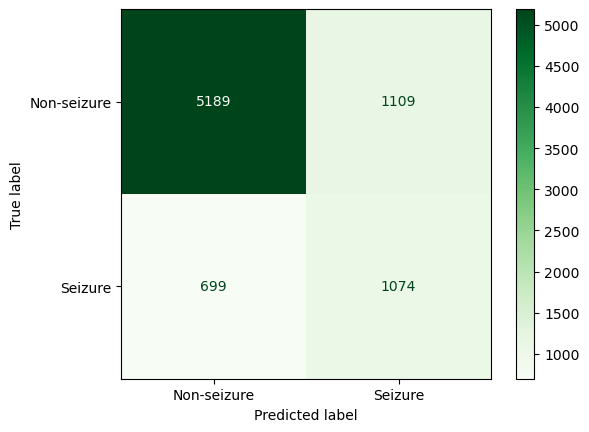

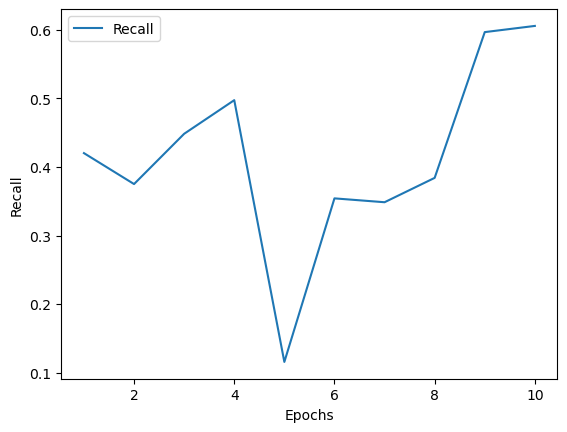

In [9]:
# Evaluating on validation data
base_nn.evaluate()

> Basic simple dense neural network achieves recall of 60%

#### Baseline comparitor using Support Vector Machine classiifier

##### Wang (2011) showed use of bandpass filter and wavelet analysis to train SVM seizure classifier [29] with good accuracy
Wavelet analysis is a mathematical signal transformation which is localised in frequency and time. Wavelet analysis uses such wavelets to perform mathematical transformation.

 1. Brain EEG signal of > 50 Hz often associated with eye movement, muscle activities etc
 2. Brain EEG signal < 1 Hz are general slow drifts in records.
 3. Useful brain activity often around 1 - 30+ Hz


Class SVM_Tools contains seven methods:
1. train_svm(data,label) -> SVM classifier trained on CHB-MIT seizure data of samples size (37666,23,256). A static method
2. get_psd(self,data_signal, frequency=256, segment_length=256)  -> numpy array of power signal density features. Unable to run CHB-MIT dataset in a single process. Numpy array size is too large to fit into memory.
3. get_psd_batch(self, batch_size=1000) -> numpy array of power signal features. Run get_psd in batches.
4. def to_svm_input(data_signal) -> numpy array with dimensions (n_samples, n_features) , where n_samples represents number of samples and n_features represents number of features, obtain by converting (n_samples, n_channels, n_datapoints) into (n_samples , n_channels x n_datapoints). This is the shape required for SVM training. A static method.
5. show_shape(self) -> returns shape of input data
6. get_wavelet(self, scales=np.arange(1,30), wavelet='cmor',batch_size=50) -> returns np.ndarray of shape (n_samples, n_features)
7. a cache decorator. see section on caching, three cells below.

Training SVM model on dataset with more than 36000 samples takes prohibitively long on my machine during rapid prototyping phase.
In first iterative phase, feature extraction feature is added to allow computation in reasonable time.
Literature review showed wavelet analysis and power spectral analysis are possible methods [29].
Wavelet analysis:
- extracts time-frequency representation
- requires higher computation resource

#### Power spectral analysis:
- analyse only frequency domain.
- lower computation resource needed.
- estimate using Welch method: divides data into overlapping segments, computing a modified periodogram for each segment. Then average the periodograms.

Feature extraction implemented.

One way to understand **wavelet** transform is to consider two steps:

Step 1: Transform the signal using wavelet mathematical functions that are localized in time and frequency. Think of an oscilloscope analysing a range of frequencies from a sound signal. The same oscilloscope is turned on and off at fixed interval. We know have a frequency-time representation of the input ssound creating a time-frequency representation of the signal.

Step 2: Scale the wavelet (stretch/compress the signal on the oscilloscope) to analyze different frequency bands (high scales (stretch signal) = low frequencies, low scales (compress signal) = high frequencies). At the same time while translating (shifting) it across different range of frequencies to capture how the signal evolves over time (think of zooming in for increased resolution or zooming out for more panoramic view ). The range of scales is specified as numpy array  : np.arange(1,30) means about 30 different 'sizes' of frequency range applied.

A way to visualise this is by imagining a wavelet function that starts out narrow (high frequency) and becomes wider (low frequency). By applying it at different scales , you zoom in and out to capture the frequency components at different levels of detail.

If still confusing - think of wavelet transformation as compressing frequency and time into a fewer numbers but representative of time-frequency information. Analogous to how mean is representative a series of integers!

##### Standardisation of input data
Input values are standardised to mean of 0 and standard deviation of 1.
1. Support Vector Machine algorithm is sensitive to scale of input, and perform  better with standardised data.
2. Ensures all features contribute equally by putting them onto a common scale.
3. Helps gradient based algorithm to converge quicker.

#### Caching
Wavelet and PSD preprocessing takes some time. Therefore, it makes sense to cache the results for efficiency.

In-built 'lre-cache' requires hashable input. Arrays have to be converted to hashable format, such as a tuple, using tuple(numpy array). This consumes memory and computation resource.

Since there are few but very large arrays to store in this programme, use of python dictionary is more efficient. Hashing is not necessary, as key name lookup for so few arrays are sufficiently efficient.

cache_decorator is implemented as a decorator. Arrays are cached as simple name-value pairs in cache_dictionary inside SVN_Tools.


In [76]:
class SVM_Tools:
    def __init__(self,data, labels):
        self.full_data = data
        self.full_labels = labels
        self.cache = {}
        self.wavelet = self.cache_decorator("wavelet")(self.get_wavelet)
        self.get_psd = self.cache_decorator("psd")(self.get_psd)

    # build and train SVM model on the CHB-MIT data signals.
    @staticmethod
    def train_svm(data, labels):
        if len(data.shape) == 2:
            X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, test_size=0.3)
        elif len(data.shape) == 3:
            n_samples, timesteps, features = data.shape
            data_reshaped = np.reshape(data, (n_samples,timesteps*features))
            X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels, train_size=0.7, test_size=0.3)
        else:
            print("Incompatible data shape")
            return

       # params = { "kernel": ["linear", "rbf"],
       #            "C": [1, 10, 100],              # Regularization parameter
       #            "gamma": [0.01, 0.1, 1, 10, 50] } # Kernel coefficient for 'rbf'
        params = { "kernel": ["linear"],
                   "C": [1],              # Regularization parameter
                   "gamma": [5] } # Kernel coefficient for 'rbf'


        # Coding technique for handling training failure
        try:
            svm = SVC(probability=True, verbose=1)

            # RandomizedSearchCV is compute intensive, use RandomSearchCv to speed up search for optimal parameters
            clf = RandomizedSearchCV(svm,param_distributions=params,cv=2,n_jobs=-1,n_iter=20)

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            #svm = SVC(C=1.0, gamma='scale', kernel='rbf', probability=True, verbose=1)
            clf.fit(X_train_scaled, y_train )
            y_predict = clf.predict(X_test_scaled)

            print(f"Best parameters set: {clf.best_params_}")
            print("\nConfusion matrix:")
            print(confusion_matrix(y_test, y_predict))
            print("\nClassification report:")
            print(classification_report(y_test, y_predict))

            return clf


            #clf = SVC(C=1.0, gamma='scale', probability=True, verbose=1)
            #clf.fit(X_train, y_train)
            #y_predict = clf.predict(X_test)




            # print("\nConfusion matrix:")
            # print(confusion_matrix(y_test, y_predict, labels=labels))
            # print("\nClassification report:")
            # print(classification_report(y_test, y_predict, labels=labels))
            #
            # return clf
        # Coding technique to allow fallback when failure due large sample size
        except MemoryError as e:
            small_sample = 1000
            print(f"Insufficient memory for SVM: {e}")
            print(f"Retrain using first {small_sample} samples,  C = 1.0, Gamma ='scale'(auto adjust to feature size)")
            # Initialise simple SVC model with common used parameters for  C and gamma
            simple_svm = SVC(kernel='linear', C=1.0, gamma='scale', probability=True, verbose=1)
            # Perform 2 fold cross validation
            cv_score = cross_val_score(simple_svm, X_train[:small_sample], y_train[:small_sample], cv=2, n_jobs=1, verbose=1)
            # Print score
            print(f"Cross validation score: {cv_score}")
            print(f"Average cross validation score: {cv_score.mean()}")
        # Error handling for all other errors
        except Exception as e:
            print(f"Failure during SVM training with error {e}")

    # feature to be extracted is the power spectral density for each channel
    def get_psd(self, frequency=256, segment_length=256) -> np.ndarray:
        # sample size too large for single step processing. Resulted in out of memory error.
        # Batch process data instead.
        # Try-Except block forms coding technique to gracefully handle error
        try:
            psd_features = []
            for channel in self.full_data:
                freq, psd = welch(x=channel, fs=frequency, nperseg=segment_length)
                psd_features.append(psd)
            return np.array(psd_features)
        except Exception as e:
            print(f"Error in calculating power spectral dnesity: {e}")
            return np.array([]) # return empty numppy array

    # Coding technique to optimise real time data handling and memory efficiency by batch processing.
    def get_psd_batch(self, batch_size=1000) -> np.ndarray:
        batch_size = 100
        full_features = []
        #pass batch size of samples to get_psd. Store it and concatenate all obtained result into single numpy array.
        for start in range(0,self.full_data.shape[1],batch_size):
            end = min(start + batch_size, self.full_data.shape[1])
            each_batch = self.full_data[:,start:end]
            batch_psd = self.get_psd(each_batch)
            full_features.append(batch_psd)

        # each batch is appended as a numpy array into full_features. Concatenate the batches into a single batch (row wise).
        full_features = np.concatenate(full_features, axis = 1)
        return full_features

    @staticmethod
    def to_svm_input(data_signal):
        """convert to n_samples x n_features which is required for SVM model training"""
        if data_signal.ndim == 2:
            return
        elif data_signal.ndim > 3:
            # flatten to 2-D shape of (number samples, number features).  i.e. (number samples , channels X datapoints)
            data_signal.reshape(data_signal,-1)
        return data_signal

    def show_shape(self):
       return self.full_data.shape

    def get_wavelet(self, save_to = 'waveletSVM.csv', scales=np.arange(1,30), wavelet='cmor',batch_size=50) -> np.ndarray:
        # results of wavelet transforms take 20 minutes to run. Save to file waveletSVM.csv
        if os.path.exists(save_to):
            wav_temp = np.loadtxt(save_to, delimiter=',')
            print("wavelet transformed file already exists. Import from file")
            return np.array(wav_temp)
        # useful brain activity 1 - 50 Hz
        # apply band filter. Remove > 50 Hz, and < 1 Hz frequencies
        # Nyquist frequency is twice the frequency that can be reconstituted from data
        # parameters to create filter using butter function from scipy.signal
        sampling_frequency = 256  # Sampling frequency from CHB-MIT dataset
        nyquist = 0.5 * sampling_frequency
        low_hz = 1
        high_hz = 50
        order = 4  # scipy.signal.butter documentation recommends 4 for bandpass

        # User Butterworth filter to create bandpass filter
        lower_limit = low_hz / nyquist
        higher_limit = high_hz / nyquist
        b,a = butter(order, [lower_limit, higher_limit], btype='band')
        # returns (numerator, denominator)

        # Apply Butterworth filter to filter data
        # returns same shaped numpy array with > 50 & < 1 values filtered out
        filtered_signals = filtfilt(b,a,self.full_data,axis =-1)
        n_samples, n_channels, n_datapoints = filtered_signals.shape

        samples_features = [] # list of features for each sample
        # for each sample, extract wavelet features for each chanel, and find mean of all channels in a sample
        for sample in range(n_samples):
            channel_features = [] # list of features for each channel
            for channel in range(n_channels):
                # perform Morlet wavelet transform using pywt library for each channel separately
                # cwt is continuo  wavelet transformation (for continuous variable)
                # 128 different scales ( "resolutions") applied using np.arange(1,128)
                coefficient, freq = pywt.cwt(filtered_signals[sample, channel], scales, wavelet)

                # coefficient are complex numbers, may be positive or negative. Squared value removes negative numbers
                # np.abs(coefficient) returns magnitude  np.abs(coefficient)**2 returns power (intensity or energy in different frequency band).
                power = np.abs(coefficient)**2

                # take mean over time axis
                feature = np.mean(power, axis = 1)
                channel_features.append(feature)

            # concatenate all channel features for this sample
            samples_features.append(np.concatenate(channel_features, axis=0))  # alternative, np.stack may be useful to create new axis
        np_features = np.array(samples_features)
        # coding technique for interoperability by saving output in standard format such as CSV.
        np.savetxt(save_to, np_features, delimiter =',')

        return np_features

    # In-build lre-cache requires hashable input. Storing post processed numpy array will require converting to a hashable form, such as a tuple using  tuple(numpy array).
    # Since there are limited number of arrays , it is  more efficient to use python dictionary.
    def cache_decorator(self,name):
        def inside_decorator(func):
            # call nested function
            def wrapper(*args,**kwargs):
                array_result = func(*args,**kwargs)
                try:
                    if not isinstance(array_result, np.ndarray):
                        array_result = np.array(array_result)
                except TypeError:
                    print("Wrong data type")
                # store key-value pair in cache_dict
                self.cache[name] = array_result
                return array_result
            return wrapper
        return inside_decorator

    # Coding technique to check input data validity - 1) arrays are numpy and 2) data and label samples match
    def validate_data(self, data, labels):
        if not isinstance(data, np.ndarray):
            raise ValueError("Data should be a NumPy array.")
        if not isinstance(labels, np.ndarray):
            raise ValueError("Labels should be a NumPy array.")
        if data.shape[0] != len(labels):
            raise ValueError("Number of samples in data must match number of labels.")



#### Implemented coding techniques
Efforts have been taken emphasising code reuse, error handling, robustness, interoperability and scalability .
These are steps taken in SVM_Tools class.

1. Code reuse: Pre-processing tool like PSD, WA, and training, cross validation steps are defined as separate methods inside SVM_Tools class.
2. Improve data handling resilience through input data dimensions and type validations. Example: validate_data method.
3. Improve memory efficiency by caching large arrays, such as wavelet analysis outputs, instead of repeating calculations whenever wavelet transformation of data is needed.
Example: get_wavelet method.
4. Testing, such as unit test custom methods for input types, boundary cases improves code robustness. This is perform separately in notebook “test_svm_tools.ipynb”. Notebook instead of single python file is chosen for ease of markings, and consistency in submitted file types.
Example: tst_svm_toolss.ipynb – unit test ensuring correct dimensions, and type for get_psd, get_wavelet methods. Unit test for successful caching and retrieval for cache_decorators method.
5. Modularity and scalability is achieved by breaking codes into different methods in a common class.
6. Save files to common formats such as npy or csv, for ease interoperability.

Potential works for next iteration
•	Break get_wavelet method. Currently method does filter and wavelet analysis. Best practice requires a method to address a single concern. ‘get_wavelet’ could be broken into filter and wavelet analysis
•	Speed up time consuming ‘get_wavelet’ function could be achieved with parallel processing. Joblib library is a good option to recode this function for parallel processing


##### Instantiate SVM class and model training

In [77]:
mysvm1 = SVM_Tools(train_signals, train_labels)

In [78]:
# show imported data shape
mysvm1.show_shape()

(37666, 23, 256)

In [79]:
# pre-processed trina_signals. Apply wavelet transformation
train_wavelet = mysvm1.get_wavelet()

wavelet transformed file already exists. Import from file


"*train_wavelet*" stores wavelet transformed train_signals.

"*train_labels*"  stores corresponding seizure labels.

**Train Support Vector Machine Classifier**

In [80]:
train_wavelet.shape, train_labels.shape

((37666, 667), (37666,))

In [81]:
# Run support vector classifier on feature extracted samples
SVM_Tools.train_svm(train_wavelet, train_labels)



C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LibSVM]Best parameters set: {'kernel': 'linear', 'gamma': 5, 'C': 1}

Confusion matrix:
[[8749  146]
 [1390 1015]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8895
           1       0.87      0.42      0.57      2405

    accuracy                           0.86     11300
   macro avg       0.87      0.70      0.74     11300
weighted avg       0.87      0.86      0.84     11300



SVC(probability=True, verbose=1)

 >Baseline SVM model using C=1, kernel='linear' achieve a recall score of 42% for seizure detection

#### First Iteration
Pre-process raw CHB-MIT samples. Segment to 10-second windows.

Performed in convert_raw.ipynb notebook and stored as **10sec_signals.npy** with corresponding binary labels (1 for seizure, 0 for no seizure) as **10sec_labels.npy**

In [5]:
# import numpy datasets

path_10signal = "10sec_signals.npy"
path_10labels = "10sec_labels.npy"
train_10sec = np.load(path_10signal)
labels_10sec =  np.load(path_10labels)

unique, counts = np.unique(labels_10sec, return_counts=True)
print(unique, counts)
print(f"Proportion of seizure samples = {counts[1]/counts[0]:.3}%")



[False  True] [9413  116]
Proportion of seizure samples = 0.0123%


In [6]:
train_10sec_data, test_10sec_data, train_10sec_labels, test_10sec_labels = train_test_split(train_10sec, labels_10sec, train_size = 0.7, test_size = 0.3)
print(f"shape of train_10sec_data: {train_10sec_data.shape}, shape of train_10sec_labels: {train_10sec_labels.shape}")
print(f"shape of test_10sec_data: {test_10sec_data.shape}, shape of test_10sec_labels: {test_10sec_labels.shape}")


shape of train_10sec_data: (6670, 18, 2048), shape of train_10sec_labels: (6670,)
shape of test_10sec_data: (2859, 18, 2048), shape of test_10sec_labels: (2859,)


#### Common sense baseline

This 10-sec window dataset contains 116 seizure samples and 9413 non-seizure samples. 0.0123% are seizure samples.

> Target sensitivity or recall of 80%


#### Baseline using dense neural network ann 10-second window

In [18]:
nn_10sec = BaseDense(train_10sec_data, train_10sec_labels, test_10sec_data, test_10sec_labels)
#standardise data range
nn_10sec.pre_process()
nn_10sec.train()

NameError: name 'BaseDense' is not defined

90/90 [==============================] - 2s 16ms/step - loss: 16.4974 - mae: 0.1033 - recall: 0.7632
 loss: 16.4974 , mae: 0.1033 , recall: 0.7632
90/90 [==============================] - 2s 20ms/step

 Confusion Matrix:


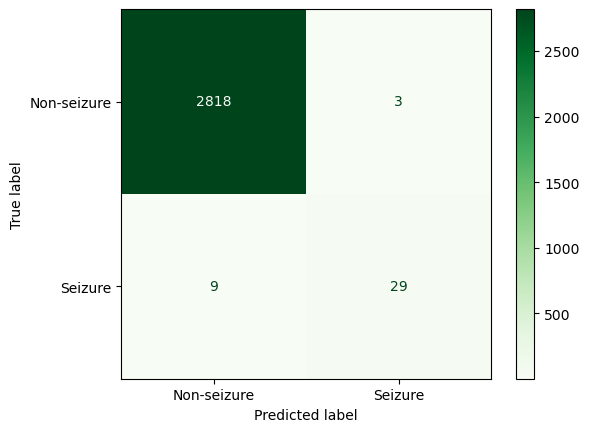

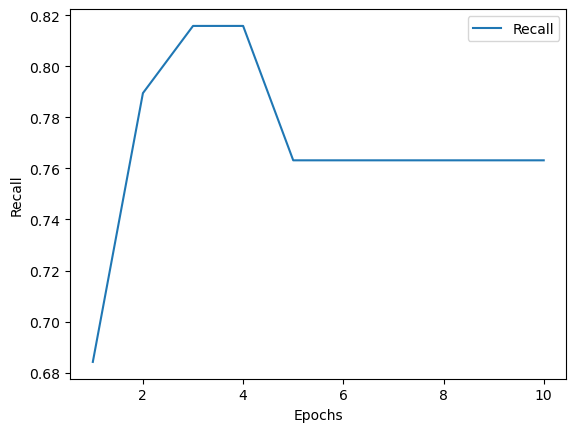

In [17]:
# test set comprises 30% of full set
nn_10sec.evaluate()

In [22]:
print(f" Recall is {29/38:.3} %")

 Recall is 0.763 %


increasing window segement from 1 second to 10 seconds (Alzahy, 2019)
> improves recall from **61%** to **76%**

#### LSTM model

The bidirectional LSTM architecture implemented follows Deepa’s design (2022).
It consists of 3 bidirectional layers,
 - Bidirectional LSTM with 128 neurons
 - Dropout layer with ratio 0.3
 - Bidirectional LSTM with 64 neurons
 - Dropout layer with ratio 0.3
 - Bidirectional LSTM with 32 neurons
 - Dense binary classification layer with sigmoid activation function.




In [9]:


class RnnModel:
    def __init__(self, train_signals, train_labels, test_signals, test_labels):
        self.train_signals = train_signals
        self.train_labels = train_labels
        self.test_signals = test_signals
        self.test_labels = test_labels
        self.model = None
        self.recall = None

    def train(self):
        # Instantiate sequential API
        model = Sequential()

        timesteps = self.train_signals.shape[1]
        features = self.train_signals.shape[2]

        # Add first Bidirectional LSTM layer
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(timesteps, features)))
        # Add dropout to prevent overfitting
        model.add(Dropout(0.3))

        # Add second Bidirectional LSTM layer
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        # Add dropout to prevent overfitting
        model.add(Dropout(0.3))

        # Add third Bidirectional LSTM layer
        model.add(Bidirectional(LSTM(32)))

        # Output layer with 1 neuron and sigmoid activation for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model with binary cross-entropy loss and Adam optimizer
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision'])

        history = model.fit(self.train_signals, self.train_labels, epochs=10, batch_size=64, validation_split=0.3)
        self.model = model
        self.recall = history.history['val_recall']

    def evaluate(self):
        loss, recall, precision  = self.model.evaluate(self.test_signals, self.test_labels)
        print(f"Test loss : {loss:.4f} , Test Recall : {recall:.4f} , Test Precision : {precision:.4f}")

        #prediction
        y_prediction = ( self.model.predict(self.test_signals) >0.5).astype(int)
        y_true = self.test_labels

        # plot confusion matrix
        cm = confusion_matrix(y_true, y_prediction)
        cm_labels = ["Non-seizure", "Seizure" ]
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels).plot(cmap=plt.cm.Blues)
        plt.show()

        # plot recall vs epochs graph
        epochs = range(1,len(self.recall)+1)
        recall = self.recall
        plt.plot(epochs, recall)
        plt.ylabel('Recall')
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()




In [10]:
bilstm = RnnModel(train_10sec_data, train_10sec_labels, test_10sec_data, test_10sec_labels)
bilstm.train()


Epoch 1/10
73/73 [==============================] - 42s 427ms/step - loss: 0.0778 - recall: 0.8136 - precision: 0.9412 - val_loss: 0.0036 - val_recall: 1.0000 - val_precision: 0.9200
Epoch 2/10
73/73 [==============================] - 9s 127ms/step - loss: 0.0022 - recall: 1.0000 - precision: 0.9672 - val_loss: 0.0036 - val_recall: 1.0000 - val_precision: 0.9200
Epoch 3/10
73/73 [==============================] - 9s 119ms/step - loss: 8.0662e-04 - recall: 1.0000 - precision: 0.9833 - val_loss: 0.0037 - val_recall: 1.0000 - val_precision: 0.9200
Epoch 4/10
73/73 [==============================] - 9s 119ms/step - loss: 2.9981e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0041 - val_recall: 1.0000 - val_precision: 0.9200
Epoch 5/10
73/73 [==============================] - 9s 119ms/step - loss: 1.6826e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0043 - val_recall: 1.0000 - val_precision: 0.9200
Epoch 6/10
73/73 [==============================] - 9s 119ms/step - loss: 1.0

90/90 [==============================] - 3s 29ms/step - loss: 0.0057 - recall: 1.0000 - precision: 0.9189
Test loss : 0.0057 , Test Recall : 1.0000 , Test Precision : 0.9189
90/90 [==============================] - 5s 27ms/step


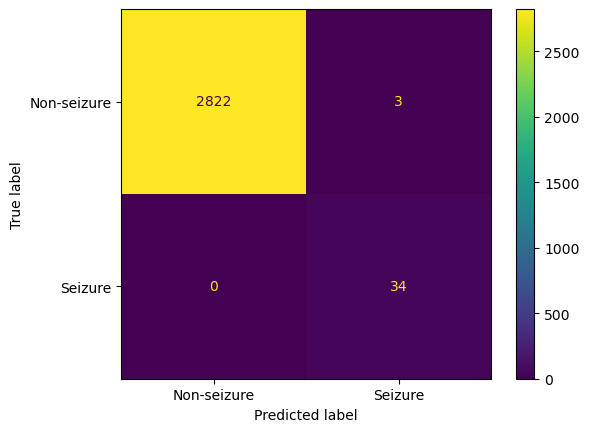

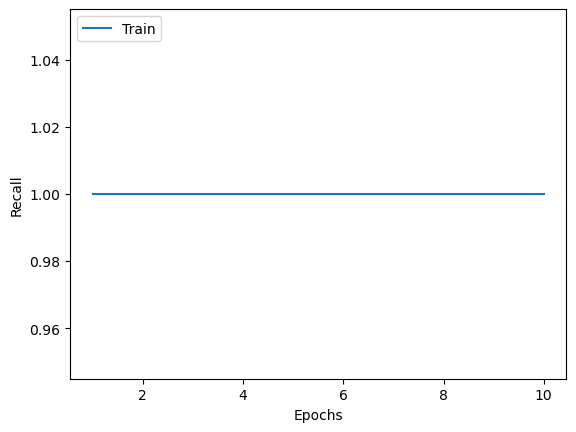

In [11]:
bilstm.evaluate()

> Overfitted

In [15]:
# Reattempt with 1 second data
sec1_model  = RnnModel(train_signals,train_labels, val_signals,val_labels)
sec1_model.train()


Epoch 1/10
412/412 [==============================] - 60s 125ms/step - loss: 0.4673 - recall: 0.1754 - precision: 0.6271 - val_loss: 0.4491 - val_recall: 0.2640 - val_precision: 0.6643
Epoch 2/10
412/412 [==============================] - 47s 114ms/step - loss: 0.4354 - recall: 0.2880 - precision: 0.6976 - val_loss: 0.4411 - val_recall: 0.2447 - val_precision: 0.7095
Epoch 3/10
412/412 [==============================] - 46s 112ms/step - loss: 0.4164 - recall: 0.3207 - precision: 0.7206 - val_loss: 0.4293 - val_recall: 0.3132 - val_precision: 0.6717
Epoch 4/10
412/412 [==============================] - 46s 113ms/step - loss: 0.4034 - recall: 0.3546 - precision: 0.7440 - val_loss: 0.4256 - val_recall: 0.2574 - val_precision: 0.7333
Epoch 5/10
412/412 [==============================] - 47s 114ms/step - loss: 0.3888 - recall: 0.3835 - precision: 0.7499 - val_loss: 0.4270 - val_recall: 0.2952 - val_precision: 0.7337
Epoch 6/10
412/412 [==============================] - 47s 115ms/step - loss

253/253 [==============================] - 7s 26ms/step - loss: 0.4307 - recall: 0.3886 - precision: 0.6709
Test loss : 0.4307 , Test Recall : 0.3886 , Test Precision : 0.6709
253/253 [==============================] - 8s 25ms/step


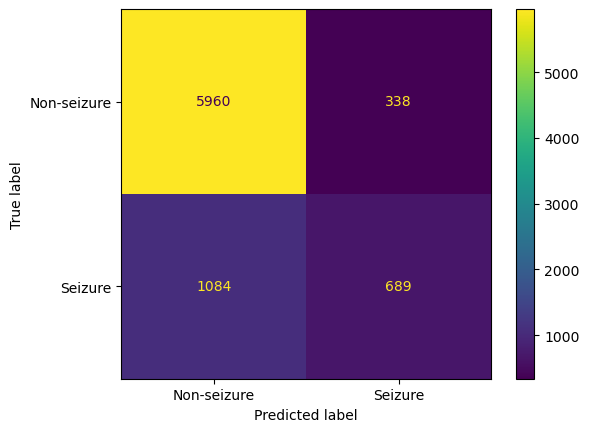

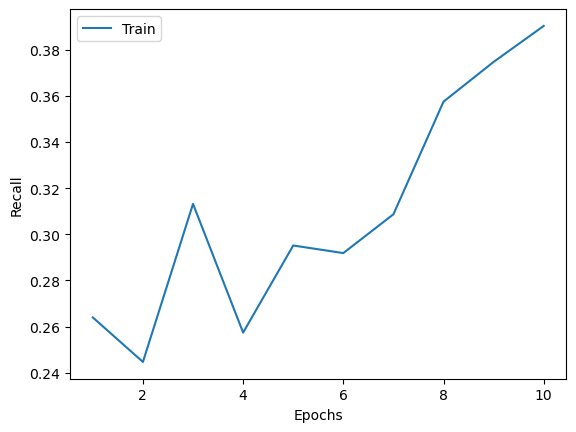

In [17]:
sec1_model.evaluate()

Training SVM model on dataset with more than 36000 samples takes prohibitively long on my machine during rapid prototyping phase.
In first iterative phase, feature extraction feature is added to allow computation in reasonable time.
Literature review showed wavelet analysis and power spectral analysis are possible methods [29].
Wavelet analysis:
- extracts time-frequency representation
- requires higher computation resource

Power spectral analysis:
- analyse only frequency domain.
- lower computation resource needed.
- estimate using Welch method: divides data into overlapping segments, computing a modified periodogram for each segment. Then average the periodograms.

Feature extraction implemented.

In [51]:
# data extracted from raw EEG edf format data has 23 channels with 256 datapoints per sample (1 second). Frequency is 256 Hz.
# feature to be extracted is the power spectral density for each channel
def get_psd(data_signal, frequency=256, segment_length=256):
    # sample size too large for single step processing. Resulted in out of memory error.
    # Batch process data instead.

    psd_features = []
    for channel in data_signal:
        freq, psd = welch(x=channel, fs=frequency, nperseg=segment_length)
        psd_features.append(psd)
    return np.array(psd_features)

# Coding technique to optimise real time data handling and memory efficiency by batch processing.
def get_psd_batch(data, batch_size=1000):
    batch_size = 100
    full_features = []
    #pass batch size of samples to get_psd. Store it and concatenate all obtained result into single numpy array.
    for start in range(0,train_signals.shape[1],batch_size):
        end = min(start + batch_size, train_signals.shape[1])
        each_batch = train_signals[:,start:end]
        batch_psd = get_psd(each_batch)
        full_features.append(batch_psd)

    # each batch is appended as a numpy array into full_features. Concatenate the batches into a single batch (row wise).
    full_features = np.concatenate(full_features, axis = 1)
    return full_features

def to_svm_input(data_signal):
    """convert to n_samples x n_features which is required for SVM model training"""
    if data_signal.ndim == 2:
        return
    elif data_signal.ndim > 3:
        # flatten to 2-D shape of (number samples, number features).  i.e. (number samples , channels X datapoints)
        data_signal.reshape(data_signal,-1)
    return data_signal




(37666, 23, 129)

In [6]:
class PrototypeModel:
    def __init__(self, shape):
        self.shape = shape

    def hybrid(self):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=self.shape))
        model.add(MaxPooling1D(pool_size=2))

        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        #model.add(Flatten())
        model.add(LSTM(128, activation='relu', return_sequences=False))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall','Precision'])
        model.summary()
        return model


In [7]:
p_model = PrototypeModel(train_signals.shape[1:])
cnn_lstm = p_model.hybrid()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 64)            49216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 1

In [8]:
callbacks = [ModelCheckpoint('seizure_CNN_LSTM.keras', save_best_only=True)]
cnn_lstm_history = cnn_lstm.fit(train_signals, train_labels, epochs=10, batch_size=32,
            validation_data=(val_signals,val_labels), callbacks=callbacks)

Epoch 1/10
1178/1178 [==============================] - 10s 7ms/step - loss: 0.7838 - recall: 0.0762 - precision: 0.3228 - val_loss: 0.5487 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
1178/1178 [==============================] - 46s 39ms/step - loss: 0.5098 - recall: 0.0873 - precision: 0.7029 - val_loss: 0.4694 - val_recall: 0.1884 - val_precision: 0.8329
Epoch 3/10
1178/1178 [==============================] - 38s 32ms/step - loss: 0.4745 - recall: 0.2306 - precision: 0.7532 - val_loss: 0.4355 - val_recall: 0.2775 - val_precision: 0.7616
Epoch 4/10
1178/1178 [==============================] - 9s 7ms/step - loss: 0.4190 - recall: 0.3161 - precision: 0.7717 - val_loss: 0.4193 - val_recall: 0.3249 - val_precision: 0.7579
Epoch 5/10
1178/1178 [==============================] - 9s 7ms/step - loss: 0.4982 - recall: 0.1215 - precision: 0.7658 - val_loss: 0.4882 - val_recall: 0.0530 - val_precision: 0.8545
Epoch 6/10
1178/1178 [==============================] - 9s 7ms/step

In [7]:
if util.find_spec('matplotlib') is None:
    print("matplotlib module not available")

In [9]:
import matplotlib.pyplot as plt
def plot_summary(history):
    epochs = range(1,len(history.history['loss'])+1)
    recall = history.history['recall']
    precision = history.history['precision']
    plt.figure()
    plt.plot(epochs, recall, 'bo', label='Recall')
    plt.plot(epochs, precision, 'g+', label='Precision')
    plt.title('Recall and Precision')
    plt.legend()
    plt.show()

r_= cnn_lstm_history.history['recall']
p_ = cnn_lstm_history.history['precision']
list(range(4,7))


[4, 5, 6]

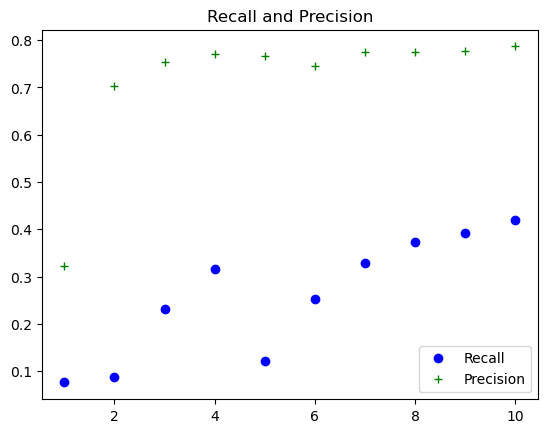

In [10]:

plot_summary(cnn_lstm.history)

In [14]:
cnn_lstm_model = load_model('seizure_CNN_LSTM.keras')


In [23]:
print(f"Test accuracy {cnn_lstm_model.evaluate(val_balanced_signals, val_balanced_labels, verbose=1)}")

111/111 [==============================] - 0s 4ms/step - loss: 0.6659 - accuracy: 0.6672
Test accuracy [0.66585373878479, 0.6672306656837463]


### References

[4] Alzahy, A., Elgammaly, M., Mohammed, H., & Mostafax, H. (2019). 'Optimal EEG Window Size for Neural Seizure Detection'. In 2019 6th International Conference on Modern Control and Automation Systems (MOCAST), pp.  1-6. IEEE.

[1] Badea A., Adam, A. 2021. CHB-MIT-Subdataset, EEG Seizure Analysis Dataset. Available from https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset [Accessed 12 November 2024].

[3] Deepa, B., & Ramesh, K. (2022). Epileptic seizure detection using deep learning through min max scaler normalization. International Journal of Health Sciences, 6(S1), 10981–10996. https://doi.org/10.53730/ijhs.v6nS1.7801

[5] Panch, T. (2019). Key challenges for delivering clinical impact with artificial intelligence. BMC Medicine, 17, pp. 1-10.

[10] Rajkomar, A. (2023). Revolutionizing healthcare: the role of artificial intelligence in clinical practice. BMC Medical Education, 23, pp. 1-15.

[29] [16] Wang, C., Zou, J.Z., Zhang, J., Chen, L.L., & Wang, M. (2011). Recognition of Epileptic EEG Using Support Vector Machines. In Wang, R. & Gu, F. (eds) Advances in Cognitive Neurodynamics (II), Chapter 4, pp. 453-459. Springer, Dordrecht.
